# Bert and SBert 

This document is dedicate to experiments with Bert and SBert models. 

## Theory review of Bert 

### Loss function(s) 
The (original) Bert model contains 2 losses: 
* **The Masked Language Modeling (MLM)**
    Given a sequence $X$, and positions $m\in\mathcal{M}:=\{1,\cdots, L\}$ in the sequence, we "mask" (e.g. hide, or replace with random token) with certain probabilities at each position, this results in the "corrupted sequence" $X_{corrupted}$. 
    Let $\theta$ be some (set of) parameters, the goal is to minimize the negative log-likelihood function 
    $$
    \mathcal{L}_{MLM}:= -\frac{1}{|\mathcal{M}|}\sum\limits_{m\in\mathcal{M}}\; log(p_{\theta}(w_m^*| X_{corrupted}))\; , 
    $$
    where $w_m^*$ is the correct token at position $m$ (in the original sequence $X$). 

* **The Next Sentence Prediction (NSP)**
    Typically, the Bert model, during training, is given a pair of sentences $(A,B)$. 
    This pair is constructed so that there is a balanced (i.e. 0.5 chance) chance of $B$ actually being the next sentence of $A$ (denoted $y=1$), and being some random sentence (that is not the next sentence of $A$) otherwise (denoted $y=0$). 
    
    In practice, the pair $(A,B)$ is tokenized into 
    $$
    [CLS](\text{tokens of }A)[SEP](\text{tokens of }B)[SEP]\;, 
    $$
    where $[CLS]$ in the "start" toekn, and $[SEP]$ is the "separation" token. 
    
    After several layers of masked multihead self attention layers (we will discuss in detail later), the leading vector ("correspond" to what $[CLS]$ "becomes" after the layers "answer" to the question of $[CLS]$) will be denoted with $h_{CLS}$. 
    It should be noted that $h_{CLS}$ does "contain information of the whole sequence of $(A,B)$". 

    We then apply the classical binary entropy with log regression with $h_{CLS}$ as feature and $y$ above as target: 
    $$
    s:=w_{NSP}^{\top}h_{CLS}+b_{NSP}\; , \text{ and }\; \hat{y}:=\sigma(s)\;, 
    $$
    where $\sigma$ is the sigmoid function. 
    And the binary cross entropy loss (to be minimized)
    $$
    \mathcal{L}_{NSP}:= -(y\; log(\hat{y}) + (1-y)log(1-\hat{y}))\; . 
    $$

+ **Combining into the joint loss**
    We combine above two loss functions into 
    $$
    \mathcal{L}:=\mathcal{L}_{MLM} + \mathcal{L}_{NSP}\; , 
    $$
    which is to be minimized. 

### Building block review - (Masked) Attention layer

The attention layer is defined as 
$$
Attention(Q,K,V):=softmax(\frac{QK^{\top}}{\sqrt{d}})V\; 
$$
where Query matrix $Q\in\mathbb{R}^{L\times d}$, Key matrix $K\in \mathbb{R}^{S\times d}$, and Value matrix $V\in \mathbb{R}^{S\times d_V}$. 
In particular, $d$ and $d_V$ are just the embedding dimensions. 

Intuitively, the attention layer "answers" questions in $Q$ with values in $V$ weighted by keys in $K$. Like you walk into a library with $Q$, and you look up the book names in $K$, and find values in are the information in the books. 

* Permutation matrix and attention layer: For any permutation matrices $A$ and $B$, we have 
    $$
    softmax(ADB)=A\;softmax(D)\;B\; ,
    $$
    for any matrix $D$. 
    This, with the fact that permutation matrices are orthogonal, imply that 
    $$
    Attention(AQ,BK,BV)=A\;Attention(Q,K,V)\; . 
    $$ 
    This means that Attention layer do NOT understand position information in $K$ and $V$. And that is why we always need a **positional embedding** to be added to the original embedding to preserve the information of position in a sequence. 

* Weights being trained: In practice, the weights being trained are the $W^*$'s in 
    $$
    Attention(QW^Q,KW^K,VW^V)\; .
    $$

    * Multihead attention: We can produce attention results on a lower dimension and concatenate the results to produce the final result later, this is multihead attention. Let's consider the case where $Q\in\mathbb{R}^{L\times d}$, $K\in \mathbb{R}^{S\times d}$, and $V\in \mathbb{R}^{S\times d}$; we take $W^Q_i\in \mathbb{R}^{d\times d_k}$, $W^K_i\in \mathbb{R}^{d\times d_k}$, and $\mathbb{R}^{d\times d_v}$, then 
    $$
    MultiHead(Q,K,V):=Concat(head_1,\cdots,head_h)W^O\;,\; \text{ where } \\ 
    head_i:=Attention(QW^Q_I, KW^K_i, VW^V_i)\;, \; 
    $$
    $h$ is the number of heads desired, and $W^O\in\mathbb{R}^{hd_v\times d}$. 

    * Masking - hiding some information in the value: 
    The definition of a masked attention is 
    $$
    Attention(Q,K,V,M):= softmax(\frac{WK^{\top}}{\sqrt{d}} + M)V\; , 
    $$
    where $M$ is of shape $L\times S$ with places we want to hide filled in with $-\infty$ and $0$ everywhere else. We will use a casual mask to see what is up: 

    (example of dimension length of Query timeseries being 3) 

    $$M:=\begin{pmatrix}
        0 & -\inf & -\inf \\ 
        0 & 0 & -\inf \\ 
        0 & 0 & 0 
    \end{pmatrix}$$

    For sake of understanding, consider following example in full: 

    $$X:=\begin{pmatrix}
        1 & 0 \\ 
        0.5 & 1 \\ 
        0 & 1.5 
    \end{pmatrix}$$

    For context, in above, the "length of timeseries $X$" is the number of row of $X$, i.e. 3. And the "dimension of each time step of $X$" is number of column of $X$ i.e. 2. 
    We will use a pythonic notation $X[i]$ to indicate the $i^th$ row of $X$ for $0\leq i\leq 2$. 

    We take $Q=K=V:=X$ (so we are doing a self attention), and have that (we are setting $\sqrt{d_Q}$ to be 1, for simplicity): 

    $$QK^T=\begin{pmatrix}
        1 & 0.5 & 0 \\ 
        0.5 & 1.25 & 1.5 \\ 
        0 & 1.5 & 2.25 
    \end{pmatrix}$$ 

    And so 

    $$QK^T+M=\begin{pmatrix}
        1 & -\inf & -\inf \\ 
        0.5 & 1.25 & -\inf \\ 
        0 & 1.5 & 2.25 
    \end{pmatrix}$$

    Then we apply the softmax on this matrix, recall definition of the soft max: 

    $$ softmax(x_{i}):=\frac{e^{x_{i}}}{\sum\limits_{j\in \text{ index set}} e^{x_{j}}} $$

    We should get something close to: 

    $$ Attn=\begin{pmatrix}
        1 & 0 & 0 \\ 
        0.32 & 0.68 & 0 \\ 
        0.06 & 0.21 & 0.73 
    \end{pmatrix} V = \begin{pmatrix}
        1 \cdot  X\left[ 0 \right] \\ 
        0.32\ \cdot  X\left[ 0 \right]  +  0.68 \cdot  X\left[ 1 \right] \\ 
        0.06\ \cdot  X\left[ 0 \right]  +  0.21 \cdot  X\left[ 1 \right]  +  0.73 \cdot  X\left[ 2 \right]
    \end{pmatrix} $$

    Notice that in practice (not in current example), $X$ as value might be "shifted down" (before even the first calculation) in the sense that $X[0]$ is set to 0, and $X[i]$ is set to the "old" $X[i-1]$ for all $i>0$ with the last row removed. As an example, the shifted down version of $X$ is 

    $$ \begin{pmatrix}0 & 0 \\ 1 & 0 \\ 0.5 & 1\end{pmatrix} $$

    Intuitively, $Attn[i]$ is only determined by $X[j]$ for $0\leq j\leq i$ for all $i$. This makes it so that "Attention with casual masking can not look into the future for current step". 

### Building block review - Layered Norm 

The following graph should clarify the difference between layered norm and batched norm - taking norm in different axis. 

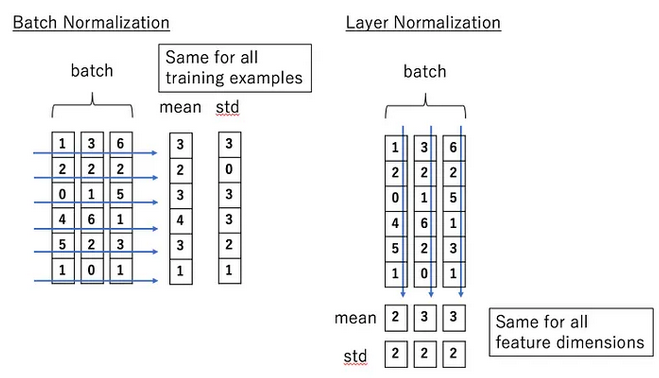

### Embedding of input 

Given a tokenized pair (of sentences) $(A,B)$ as 
$$
[CLS], a_1, \cdots, a_m, [SEP], b_1, \cdots, b_n, [SEP]\; , 
$$
which is padded to a certain length $L$ to create the full sequence $\mathcal{S}$. 

Let the token at position $i$ in $\mathcal{S}$ be with token id $t_i\in \{0,\cdots, V-1\}$ where $V$ is the total vocabulary count, 
we create three learned embeddings: 
* The token embedding $E\in \mathbb{R}^{V\times d}$ where $d$ is the embedding dimension. 
* Positional embedding $P\in \mathbb{R}^{L\times d}$, this is needed as attention layers "do not understand" position for Key and Value. 
* Segment embedding $S\in \mathbb{R}^{2\times d}$ with $0$ for $A$ and $1$ for $B$. 

These three learned embeddings are, then, combined into the full embedding of a token in this specific sequence $\mathcal{S}$. 
For position $i$ of $\mathcal{S}$ with token id $t_i$ and segment id $s_i\in\{0,1\}$, its full embedding (in $\mathcal{S}$) is 
$$
x_i^{\mathcal{S}}:=E[t_i] + P[i] + S[s_i]\in \mathbb{R}^d\; . 
$$
Perform above full embedding on the whole $\mathcal{S}$ and receive $X_{\mathcal{S}}:=(x_1^{\mathcal{S}},\cdots, x_L^{\mathcal{S}})\in \mathbb{R}^{L\times d}$. 

### The Masking matrix $M$ 

Let's say, as an example, we want to hide the $i^{th}$ token $\mathcal{S}$, we when start with a masking matrix $M\in^{L\times L}$ full of $0$, and change all the entries of the $i^{th}$ column of $M$ all into $-\infty$. 
To get an intuition of why this works, see [Masking section of above](#building-block-review---masked-attention-layer). 

It should be noted this $M$ has two parts: 
* One part is the "corrupting" mask that hides actual tokens for MLM loss. 
* The other is the "erase padding" mask, it hides the padding so that they have no impact in training. 

### The training encoder based model 

A typical training encoder for this model consists of the following layers (with given input $X$), in order 

1. $Multihead(Q=X, K=X, V=X, M)$, with possible dropouts. 
2. Layered Norm, with possible additive residue preservation (i.e. add the input back again). 
3. Feed forward layer(s). 

The typical training model will repeat above encoder for several times in sequence. 

After several layers of the encoders, let's say, we receive $H=(h_1=h_{CLS}, h_2, \cdots, h_L)\in \mathbb{R}^{L\times d}$. 
Let's assume that we have "corrupted" the actual toekn at position $i$, we then want to "translate" $h_i$ into a form that can predict the actual token. 
We use a softmax method to produce a vector of probability 
$$
z_i:=W_{lm}h_i + b_{lm}\in \mathbb{R}^{V}\; , \text{ and } p_{\theta}(w|X_{corrupted}) := softmax(z_i)_{w}\; , 
$$
where $softmax(z_i)_{w}$ is the value at index being the token id for $w$ in $softmax(z_i)$. 

## Theory review of SBert 

The goal of SBert is to promote similarity with help of encoders, we will provide following example. 

We choose and fix a baseline encoder with certain parameter $\theta$ (e.g. the Bert encoder with only the padding mask and WITHOUT any corruption mask), which we denote with following 
$$
H:=(h_1,\cdots, h_L):=H_{\theta}(s)\in\mathbb{R}^{L\times d}\; , 
$$
where $s$ is a sentence padded to length $L$. 

We then choose a pooling function, for instance, the mean polling 
$$
u:=P_{mean}(H) = \frac{1}{\sum_{l=1}^L m_l}\sum\limits_{l=1}^L m_lh_l\; , 
$$
where $m_l$ is the "anti-padding-indicator" so that $m_l=1$ if position l is NOT a padding, and $0$ otherwise. 
There are otherwise pooling functions, for instance, we may simply choose $h_{CLS}=h_1$ as the pooling (this is called the CLS pooling). 

Above will embed sentence $s$ to be a vector $u$. 

I practice, SBert needs some kind of human (or outside) intervention to inform of what sentences are similar (or even a continuous quantitative value indicating how much are two sentences similar to each other). 
After the similarity information is provided, the goal is to "drag" similar sentences "closer" by training both the encoder, and the pooling function. 

We will provide an example of this with the **Triplet Loss**: Consider given similarity information so that $s$ is similar to $s_+$ but not similar to $s_-$, we then can define the Triplet loss (to be minimized)
$$
\mathcal{L}_{triplet}:=max[\gamma - cos(f(s), f(s_+)) + cos(f(s), f(s_-)), 0]\;, 
$$
where $f$ is the embedding function (including the encoder and the pooling), and $\gamma>0$ is some chosen constant. This loss, if minimized, can promote similarity and demote anti-similarity. 